# (Homework) Week 6 - DataScience Bootcamp Fall 2025

All solution cells are replaced with `# TODO` placeholders so you can fill them in.

**Name:** Xuying Yang
**Email:**

---

### Problem 1: Dataset Splitting

1. You have recordings of 44 phones from 100 people; each person records ~200 phones/day for 5 days.
   - Design a valid training/validation/test split strategy that ensures the model generalizes to **new speakers**.

2. You now receive an additional dataset of 10,000 phone recordings from **Kilian**, a single speaker.
   - You must train a model that performs well **specifically for Kilian**, while also maintaining generalization.

*Describe your proposed split strategy and reasoning.* (Theory)

#Todo

Q1: I proposed performing a speaker-exclusive split, by assigning different speakers to training, validation, and test sets:

Train: ~80 speakers
Validation: ~10 speakers
Test: ~10 completely unseen speakers

This prevents speaker leakage and ensures that the performance on the test set reflects generalization to new speakers, not memorization of vocal characteristics.

Q2: This should use a two-stage training procedure and make data set split as follows:

Stage 1 – General model (speaker-independent):
Train a base model on the original multi-speaker dataset using a speaker-exclusive split:
-Training set: 80 speakers
-Validation set: 10 different speakers
-Held-out speakers: 10 speakers that are not used in any training or validation step.

Stage 2 – Kilian-specific fine-tuning:
Then adapt the base model to Kilian using only his data:
-Kilian train: 80% of Kilian’s recordings
-Kilian validation: 10% of his recordings (for early stopping / hyperparameter tuning)

Finally, use two separate test sets:

Test set 1 (generalization): the 10 held-out speakers from the original dataset, which are never seen during training or fine-tuning. This measures how well the model still generalizes to new speakers.

Test set 2 (Kilian adaptation): Kilian’s held-out 10% data, which measures how well the adapted model performs specifically for Kilian.

This split avoids speaker leakage, allows us to adapt the model to Kilian, and still provides a clean evaluation of generalization to unseen speakers.

### Problem 2: K-Nearest Neighbors

1. **1-NN Classification:** Given dataset:

   Positive: (1,2), (1,4), (5,4)

   Negative: (3,1), (3,2)

   Plot the 1-NN decision boundary and classify new points visually.

2. **Feature Scaling:** Consider dataset:

   Positive: (100,2), (100,4), (500,4)

   Negative: (300,1), (300,2)

   What would the 1-NN classify point (500,1) as **before and after scaling** to [0,1] per feature?

3. **Handling Missing Values:** How can you modify K-NN to handle missing features in a test point?

4. **High-dimensional Data:** Why can K-NN still work well for images even with thousands of pixels?


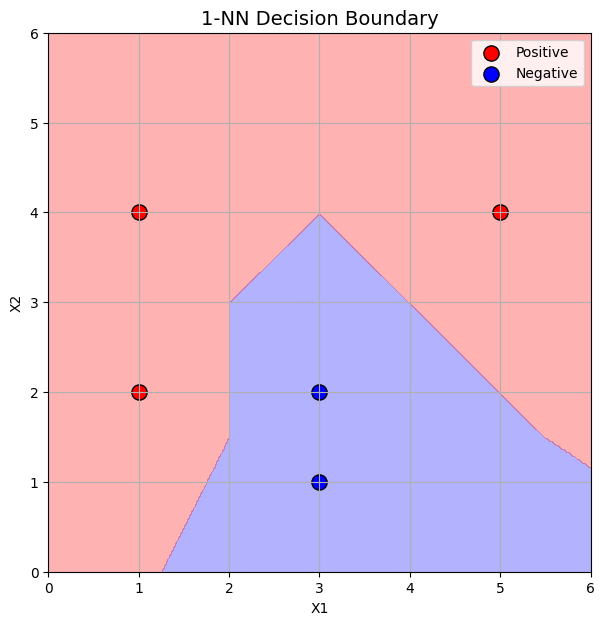

In [8]:
#1-NN classification

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# Dataset
positive = np.array([[1,2], [1,4], [5,4]])
negative = np.array([[3,1], [3,2]])

X = np.vstack([positive, negative])
y = np.array([1]*3 + [0]*2)  # 1=Positive, 0=Negative

# Train 1-NN model
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)

# Create mesh grid
x_min, x_max = 0, 6
y_min, y_max = 0, 6
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid_points = np.c_[xx.ravel(), yy.ravel()]

Z = knn.predict(grid_points)
Z = Z.reshape(xx.shape)

# Plot
plt.figure(figsize=(7,7))
plt.contourf(xx, yy, Z, alpha=0.3, levels=[-1,0,1], colors=['blue','red'])

# Plot dataset points
plt.scatter(positive[:,0], positive[:,1], c='red', edgecolors='black', s=120, label='Positive')
plt.scatter(negative[:,0], negative[:,1], c='blue', edgecolors='black', s=120, label='Negative')

plt.title("1-NN Decision Boundary", fontsize=14)
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.grid(True)
plt.show()


In [2]:
#2 feature scaling
# To avoid number difference affecting distance calculations, scale features to the same range [0,1]. 

import numpy as np

# Positive & Negative points
positive = np.array([[100, 2],
                     [100, 4],
                     [500, 4]])

negative = np.array([[300, 1],
                     [300, 2]])
X = np.vstack([positive, negative])
y = np.array([1]*len(positive) + [0]*len(negative))

# test point
test_point = np.array([[500, 1]])  # shape (1,2)

def knn_1_predict(X, y, x_query):
    """
    简单的 1-NN 分类：
    - X: 训练样本 (n_samples, n_features)
    - y: 标签 (n_samples,)
    - x_query: 待分类点，形状 (1, n_features)
    """
    # calculate KNN distances
    diffs = X - x_query  # (n_samples, 2)
    dists = np.sqrt(np.sum(diffs**2, axis=1))  # calculate Euclidean distances

    nn_idx = np.argmin(dists)
    nn_label = y[nn_idx]
    return nn_label, nn_idx, dists

# before scaling

label_before, idx_before, dists_before = knn_1_predict(X, y, test_point) #array 

print("=== Before Scaling ===")
print("Training points (X):")
print(X)
print("\nLabels (y):", y)
print("\nTest point:", test_point[0])

print("\nDistances from test point to each training point:")
for i, d in enumerate(dists_before):
    print(f"  Point {i}: {X[i]}  -> distance = {d:.2f}, label = {y[i]}")

print(f"\nNearest neighbor (before scaling): index = {idx_before}, point = {X[idx_before]}, label = {label_before}")
print("Prediction before scaling:", "Positive" if label_before == 1 else "Negative")


# =========================
# Min-Max scaling to [0,1]
# =========================

# calculate mins and maxs for each feature
mins = X.min(axis=0)
maxs = X.max(axis=0)

print("\n\n=== Feature Scaling (Min-Max to [0,1]) ===")
print("Feature mins:", mins)
print("Feature maxs:", maxs)

# 避免除以 0 的情况（这里不会发生，但写一下更安全）
ranges = maxs - mins
ranges[ranges == 0] = 1.0

# scale training points and test point
X_scaled = (X - mins) / ranges
test_scaled = (test_point - mins) / ranges # always use training mins and maxs to scale test points to avoida data leakage

print("\nScaled training points (X_scaled):")
print(X_scaled)
print("\nScaled test point:", test_scaled[0]) # 1D array


# =========================
# Classification after scaling
# =========================

label_after, idx_after, dists_after = knn_1_predict(X_scaled, y, test_scaled)

print("\nDistances from SCALED test point to SCALED training points:")
for i, d in enumerate(dists_after):
    print(f"  Point {i}: {X_scaled[i]}  -> distance = {d:.2f}, label = {y[i]}")

print(f"\nNearest neighbor (after scaling): index = {idx_after}, point = {X[idx_after]}, label = {label_after}")
print("Prediction after scaling:", "Positive" if label_after == 1 else "Negative")


=== Before Scaling ===
Training points (X):
[[100   2]
 [100   4]
 [500   4]
 [300   1]
 [300   2]]

Labels (y): [1 1 1 0 0]

Test point: [500   1]

Distances from test point to each training point:
  Point 0: [100   2]  -> distance = 400.00, label = 1
  Point 1: [100   4]  -> distance = 400.01, label = 1
  Point 2: [500   4]  -> distance = 3.00, label = 1
  Point 3: [300   1]  -> distance = 200.00, label = 0
  Point 4: [300   2]  -> distance = 200.00, label = 0

Nearest neighbor (before scaling): index = 2, point = [500   4], label = 1
Prediction before scaling: Positive


=== Feature Scaling (Min-Max to [0,1]) ===
Feature mins: [100   1]
Feature maxs: [500   4]

Scaled training points (X_scaled):
[[0.         0.33333333]
 [0.         1.        ]
 [1.         1.        ]
 [0.5        0.        ]
 [0.5        0.33333333]]

Scaled test point: [1. 0.]

Distances from SCALED test point to SCALED training points:
  Point 0: [0.         0.33333333]  -> distance = 1.05, label = 1
  Point 1: 

# 3 
KNN relies on disstance computation, so missing features can be handled in the following ways to keep Eucliean distance computation.
1. delete this test point. This method is simple without introducing new data.
2. ignore misssing features and compute distances only on the available features. This method doesn't introduce articifial values and preserves the original KNN structure. The weakness of this method is that some informative features may be ignored.
3. makeup the missing features. For example, fill the missing features using the nearest neighbors features computed on available features, then run standard KNN.This method uses full feature space after imputation. The disadvantage of this method is that it introduces bias and needs extra computation.

#4  
K-NN generally does not work well when applied directly to raw, high-dimensional pixel data due to the Curse of Dimensionality, where distances lose meaning.However, K-NN works effectively in image processing because it is applied after a critical step: Feature Extraction and Dimensionality Reduction.  

In a reduced, semantic space, proximity is meaningful. Distances accurately reflect image similarity. K-NN then performs its classification effectively within this meaningful feature space.In short: K-NN is not overcoming the curse of dimensionality; it is operating on high-quality, low-dimensional features extracted space.

### Problem 3: Part 1

You are given a fully trained Perceptron model with weight vector **w**, along with training set **D_TR** and test set **D_TE**.

1. Your co-worker suggests evaluating $h(x) = sign(w \cdot x)$ for every $(x, y)$ in D_TR and D_TE. Does this help determine whether test error is higher than training error?
2. Why is there no need to compute training error explicitly for the Perceptron algorithm?

In [ ]:
# 1. Yes — evaluating h(x)=𝑠𝑖𝑔𝑛(𝑤⋅𝑥) on both D_TR and D_TE does let us determine whether test error is higher.  
""""
This is exactly how we compute training and test error in Perceptron (or any classifier).                               
"""

In [ ]:
# 2. The logic of Perceptron algorithem is to find a hyperplane that separates the positive and negative samples in the training data. 
# If such a hyperplane exists, the algorithm will converge to a solution that classifies all, in this case, the error of the trainsing data is zero. Thus, there's no need to explicitly compute the trainning error.

### Problem 3: Two-point 2D Dataset (Part 2)

Run the Perceptron algorithm **by hand or in code** on the following data:

1. Positive class: (10, -2)
2. Negative class: (12, 2)

Start with $w_0 = (0, 0)$ and a learning rate of 1.

- Compute how many updates are required until convergence.
- Write down the sequence of $w_i$ vectors.

In [10]:
# Todo --- IGNORE ---                       
import numpy as np
X = np.array([[10,-2], [12,2]])
y = np.array([1, -1])

w = np.array([0, 0])
eta=learning_rate = 1

weights = [w.copy()]
max_epochs=15 # to prevent infinite loops

for epoch in range(max_epochs):
    error_count = 0
    print(f"\nEpoch {epoch}, start w = {w}")
    
    for i in range(len(X)):
        x_i, y_i = X[i], y[i]
        
        # condition： y_i * (w · x_i) <= 0
        margin = y_i * np.dot(w, x_i)
        print(f"  sample {i}, x={x_i}, y={y_i}, y*(w·x)={margin}")
        
        if margin <= 0:
            # 误分类 → 更新
            w = w + eta * y_i * x_i
            weights.append(w.copy())
            error_count += 1
            print(f"    -> mistake, update w to {w}")
        print(f" error_count={error_count}")   
    if error_count == 0:
        print("\nConverged.")
        break

print("\nFinal w:", w)
print("Total updates:", len(weights) - 1)

print("\nSequence of w_i:")
for t, w_t in enumerate(weights):
    print(f"  w_{t} = {w_t}")   

# perceptron algorithm enumerates all the training data in each epoch. Perceptron alogrithm only stops when all the sampel data are predicated corectly or reaching the max epoch.



Epoch 0, start w = [0 0]
  sample 0, x=[10 -2], y=1, y*(w·x)=0
    -> mistake, update w to [10 -2]
 error_count=1
  sample 1, x=[12  2], y=-1, y*(w·x)=-116
    -> mistake, update w to [-2 -4]
 error_count=2

Epoch 1, start w = [-2 -4]
  sample 0, x=[10 -2], y=1, y*(w·x)=-12
    -> mistake, update w to [ 8 -6]
 error_count=1
  sample 1, x=[12  2], y=-1, y*(w·x)=-84
    -> mistake, update w to [-4 -8]
 error_count=2

Epoch 2, start w = [-4 -8]
  sample 0, x=[10 -2], y=1, y*(w·x)=-24
    -> mistake, update w to [  6 -10]
 error_count=1
  sample 1, x=[12  2], y=-1, y*(w·x)=-52
    -> mistake, update w to [ -6 -12]
 error_count=2

Epoch 3, start w = [ -6 -12]
  sample 0, x=[10 -2], y=1, y*(w·x)=-36
    -> mistake, update w to [  4 -14]
 error_count=1
  sample 1, x=[12  2], y=-1, y*(w·x)=-20
    -> mistake, update w to [ -8 -16]
 error_count=2

Epoch 4, start w = [ -8 -16]
  sample 0, x=[10 -2], y=1, y*(w·x)=-48
    -> mistake, update w to [  2 -18]
 error_count=1
  sample 1, x=[12  2], y=-

### Problem 4: Reconstructing the Weight Vector

Given the log of Perceptron updates:

| x | y | count |
|---|---|--------|
| (0, 0, 0, 0, 4) | +1 | 2 |
| (0, 0, 6, 5, 0) | +1 | 1 |
| (3, 0, 0, 0, 0) | -1 | 1 |
| (0, 9, 3, 6, 0) | -1 | 1 |
| (0, 1, 0, 2, 5) | -1 | 1 |

Assume learning rate = 1 and initial weight $w_0 = (0, 0, 0, 0, 0)$.

Compute the final weight vector after all updates.

In [25]:
#Todo   

import numpy as np
X = np.array([[0,0,0,0,4], [0,0,6,5,0],[3,0,0,0,0],[0,9,3,6,0],[0,1,0,2,5]])
y= np.array([1,1,-1,-1,-1])
count =np.array([2,1,1,1,1])    

w = np.array([0,0,0,0,0],dtype=float)
eta=1
for i in range(len(X)):
    w = w + eta * count[i] * y[i] * X[i]
    
print("Final w:", w)


Final w: [ -3. -10.   3.  -3.   3.]


### Problem 5: Visualizing Perceptron Convergence

Implement a Perceptron on a small 2D dataset with positive and negative examples.

- Plot the data points.
- After each update, visualize the decision boundary.
- Show how it converges to a stable separator.

Perceptron converged at epoch 23.


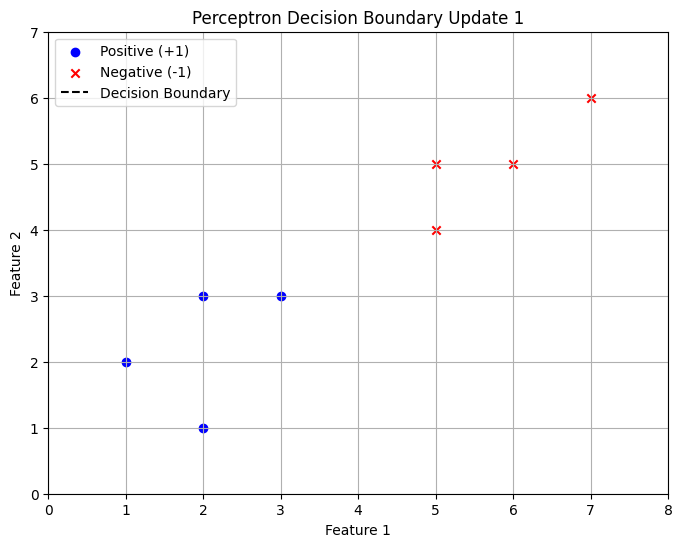

In [29]:
#Todo   
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# data preparation
X = np.array([
    [1, 2], [2, 3], [3, 3], [2, 1], # Positive examples
    [5, 4], [6, 5], [7, 6], [5, 5]  # Negative examples
])
y = np.array([1, 1, 1, 1, -1, -1, -1, -1])

# implementation of Perceptron algorithm
class Perceptron:
    def __init__(self, learning_rate=1.0, max_epochs=100):
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.weights = None
        self.bias = None
        self.history = [] # restoring updates (weights, bias)

    def predict(self, X_input):
        return np.sign(np.dot(X_input, self.weights) + self.bias)

    def train(self, X_train, y_train):
        num_features = X_train.shape[1]
        self.weights = np.zeros(num_features) 
        self.bias = 0.0 

        for epoch in range(self.max_epochs):
            errors_this_epoch = 0
           
            for i in range(len(X_train)):
                x_i = X_train[i]
                y_i = y_train[i]

                prediction = self.predict(x_i)

                if prediction != y_i:
                    self.weights += self.learning_rate * y_i * x_i
                    self.bias += self.learning_rate * y_i
                    errors_this_epoch += 1
                    # 记录更新后的权重和偏置，用于可视化
                    self.history.append((self.weights.copy(), self.bias))
            
            if errors_this_epoch == 0:
                print(f"Perceptron converged at epoch {epoch + 1}.")
                break
        
        if errors_this_epoch > 0:
            print(f"Perceptron finished after {self.max_epochs} epochs (did not fully converge).")

# Visualization 
def plot_decision_boundary(ax, weights, bias, X_data, y_data, epoch_info=""):
    ax.clear()

    ax.scatter(X_data[y_data == 1, 0], X_data[y_data == 1, 1], color='blue', marker='o', label='Positive (+1)')
    ax.scatter(X_data[y_data == -1, 0], X_data[y_data == -1, 1], color='red', marker='x', label='Negative (-1)')

    # 绘制决策边界
    # 决策边界方程: w[0]*x1 + w[1]*x2 + bias = 0
    # => x2 = (-w[0]*x1 - bias) / w[1]
    if weights[1] != 0: # 避免除以零
        x1_min, x1_max = X_data[:, 0].min() - 1, X_data[:, 0].max() + 1
        x1_boundary = np.linspace(x1_min, x1_max, 100)
        x2_boundary = (-weights[0] * x1_boundary - bias) / weights[1]
        ax.plot(x1_boundary, x2_boundary, 'k--', label='Decision Boundary')
    else: # 如果 w[1] 为零，决策边界是垂直线
        ax.axvline(-bias / weights[0], color='k', linestyle='--', label='Decision Boundary')

    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(f"Perceptron Decision Boundary {epoch_info}")
    ax.legend()
    ax.set_xlim(X_data[:, 0].min() - 1, X_data[:, 0].max() + 1)
    ax.set_ylim(X_data[:, 1].min() - 1, X_data[:, 1].max() + 1)
    ax.grid(True)


# --- 4. 执行 Perceptron 训练并动画化可视化 ---
if __name__ == "__main__":
    perceptron = Perceptron(learning_rate=0.1) # 使用稍小的学习率效果会更平滑
    perceptron.train(X, y)

    # 初始化绘图
    fig, ax = plt.subplots(figsize=(8, 6))

    # 创建动画
    # initial_frame_idx = 0 
    # 如果希望动画从更新后的第一个边界开始，可以将 initial_frame_idx 设为 0
    # 如果希望动画从 w0, b0 的边界开始，需要把 (w0, b0) 加入 history
    
    # 动画帧更新函数
    def update(frame):
        current_weights, current_bias = perceptron.history[frame]
        plot_decision_boundary(ax, current_weights, current_bias, X, y, f"Update {frame + 1}")

    # 如果 history 为空（即模型初始化后一次更新都没有就收敛了），则直接绘制最终边界
    if not perceptron.history:
        plot_decision_boundary(ax, perceptron.weights, perceptron.bias, X, y, "Final (No updates needed)")
        plt.show()    
    else:
        # 创建一个初始帧，显示开始时的边界（如果需要的话，或者直接从第一个更新开始）
        # 这里动画直接从第一个更新的边界开始
        ani = FuncAnimation(fig, update, frames=len(perceptron.history), repeat=False, interval=200) # interval 是每帧间隔毫秒

        # 保存为 GIF (需要安装 imagemagick 或 pillow)
        # ani.save('perceptron_convergence.gif', writer='pillow', fps=5)
        from IPython.display import HTML
        display(HTML(ani.to_jshtml()))